In [18]:
import os
import joblib
import kornia
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
train_img, train_lbl = torch.load('../intermediates/train.pt')
train_set = TensorDataset(train_img, train_lbl)

le = joblib.load('../intermediates/label_encoder.joblib')
num_classes = len(le.classes_)

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

augmentation = kornia.augmentation.AugmentationSequential(
                    kornia.augmentation.RandomHorizontalFlip(),
                    kornia.augmentation.RandomAffine(degrees=10.0, translate=(0.1, 0.1), scale=(0.9, 1.2)),
                    #kornia.augmentation.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                    #kornia.color.AdjustContrast(0.1),
                    kornia.enhance.Normalize(mean, std),  # Include normalization in the pipeline
                    data_keys=["input"]
                )
#Instantiating the training Objects
device = ('cuda' if torch.cuda.is_available() else 'cpu') #parameterized this later
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)

In [9]:
it = iter(train_loader)
img_batch, lbl_batch = next(it)

In [10]:
img_batch.shape

torch.Size([64, 3, 224, 224])

In [41]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def return_weights(model, image, augmentation, save_path):
    for name, layer in model._modules.items():
        layer.register_forward_hook(get_activation(name))
    image = augmentation(image)
    output = model(image)
    all_activations = torch.cat([act.flatten(1) for act in activation.values()], dim=1)
    for name, act in activation.items():
        # Move the activation to CPU and convert to numpy
        act_np = act.cpu().numpy()
        
        # Flatten the tensor to 1D
        act_np = act_np.flatten()
        print(act_np.mean(), act_np.std())
        # Create the histogram
        plt.figure(figsize=(10, 7))
        plt.hist(act_np, bins=100)
        plt.title(f'Histogram of Activations for {name} mean: {act_np.mean()} std: {act_np.mean()}')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.savefig(save_path + '/' + name + '.png')
        plt.show()


In [45]:
resnet34 = torchvision.models.resnet34(pretrained=False)
num_ftrs = resnet34.fc.in_features
resnet34.fc = torch.nn.Linear(num_ftrs, 120)  # Assuming the weights expect 120 classes

state_dict = torch.load('../model_weights/ResNet34.pt')
resnet34.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', 'layer1.2.bn2.running_mean', 'layer1.2.bn2.running_var', 'layer2.2.conv1.weight', 'layer2.2.bn1.weight', 'layer2.2.bn1.bias', 'layer2.2.bn1.running_mean', 'layer2.2.bn1.running_var', 'layer2.2.conv2.weight', 'layer2.2.bn2.weight', 'layer2.2.bn2.bias', 'layer2.2.bn2.running_mean', 'layer2.2.bn2.running_var', 'layer2.3.conv1.weight', 'layer2.3.bn1.weight', 'layer2.3.bn1.bias', 'layer2.3.bn1.running_mean', 'layer2.3.bn1.running_var', 'layer2.3.conv2.weight', 'layer2.3.bn2.weight', 'layer2.3.bn2.bias', 'layer2.3.bn2.running_mean', 'layer2.3.bn2.running_var', 'layer3.2.conv1.weight', 'layer3.2.bn1.weight', 'layer3.2.bn1.bias', 'layer3.2.bn1.running_mean', 'layer3.2.bn1.running_var', 'layer3.2.conv2.weight', 'layer3.2.bn2.weight', 'layer3.2.bn2.bias', 'layer3.2.bn2.run

-0.0025624994 2.3905382


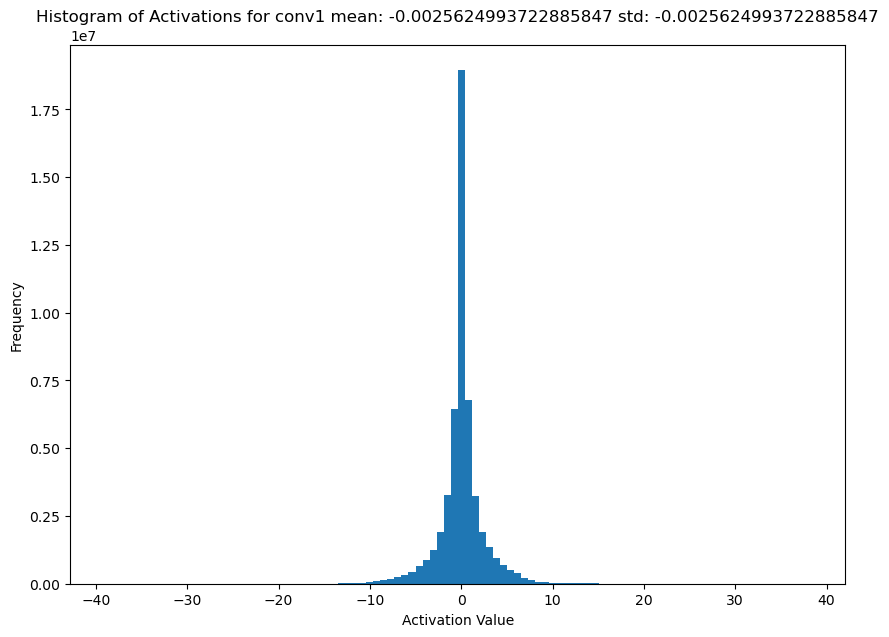

0.25221708 0.28308663


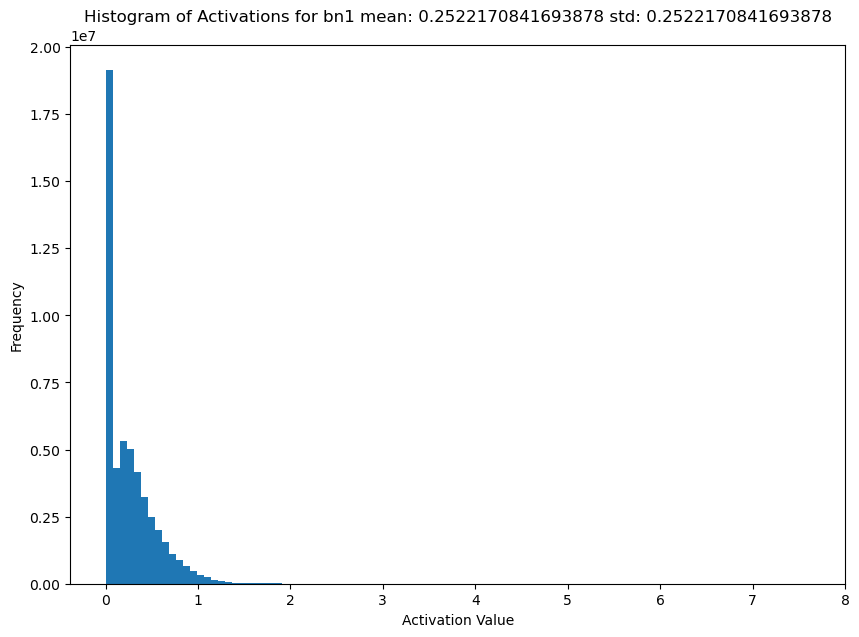

0.25221708 0.28308663


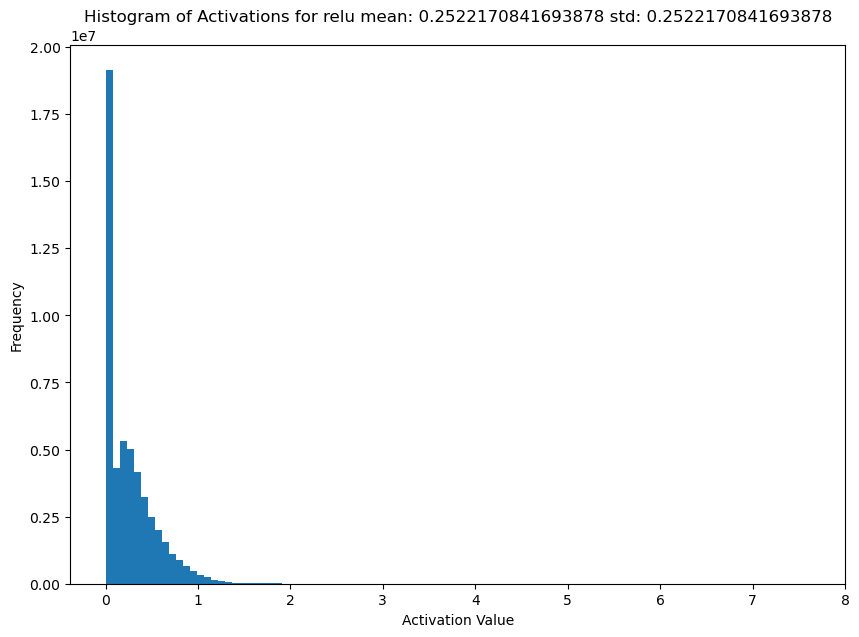

0.38175192 0.36201277


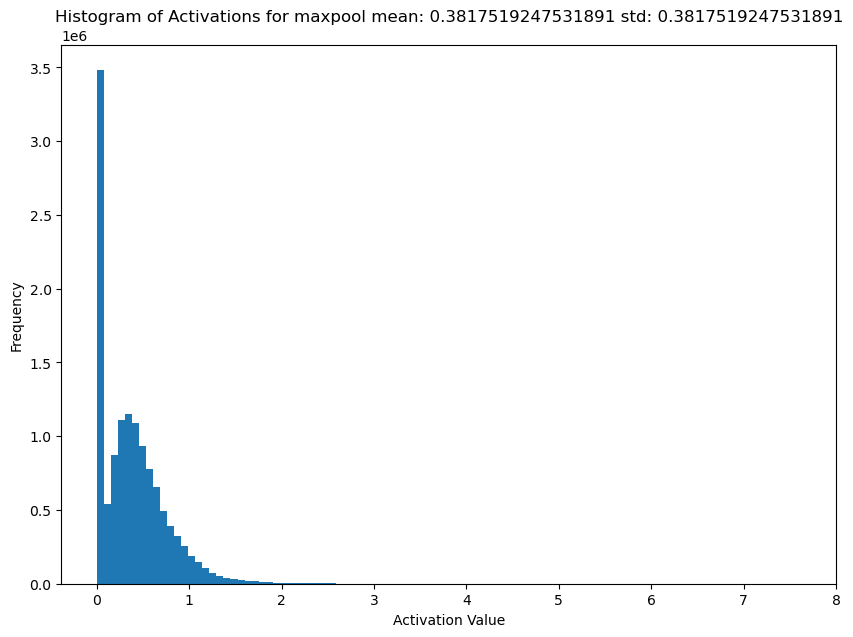

0.7220632 0.8359912


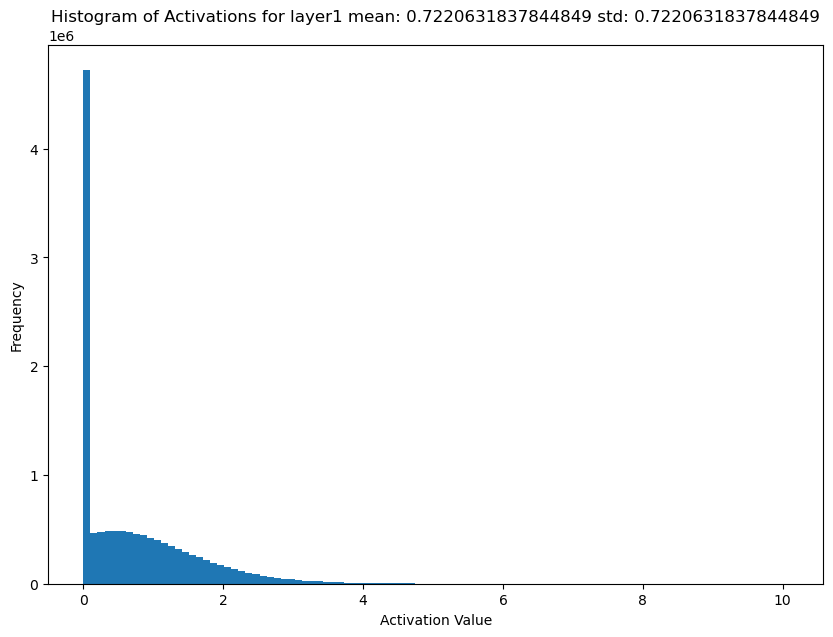

0.73430955 0.88559437


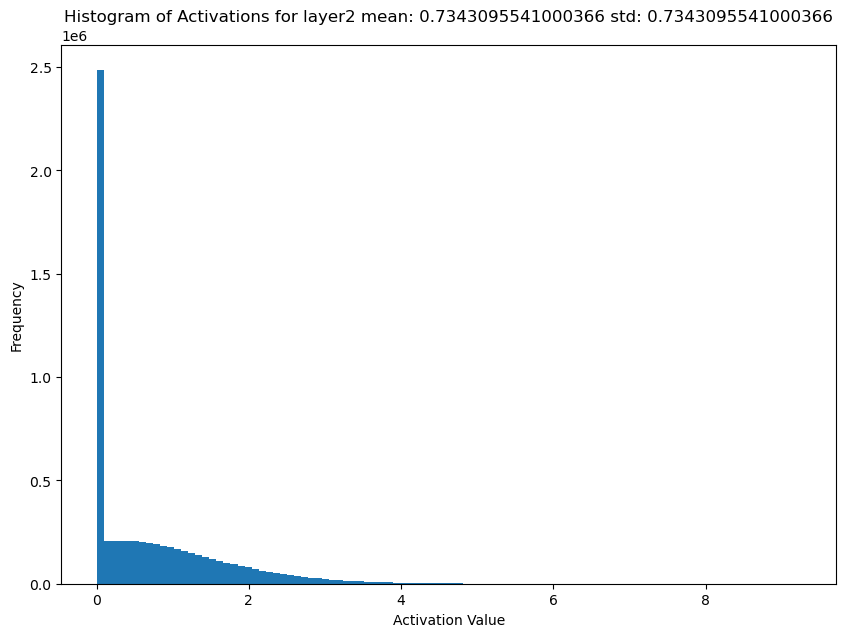

1.1219257 1.2098836


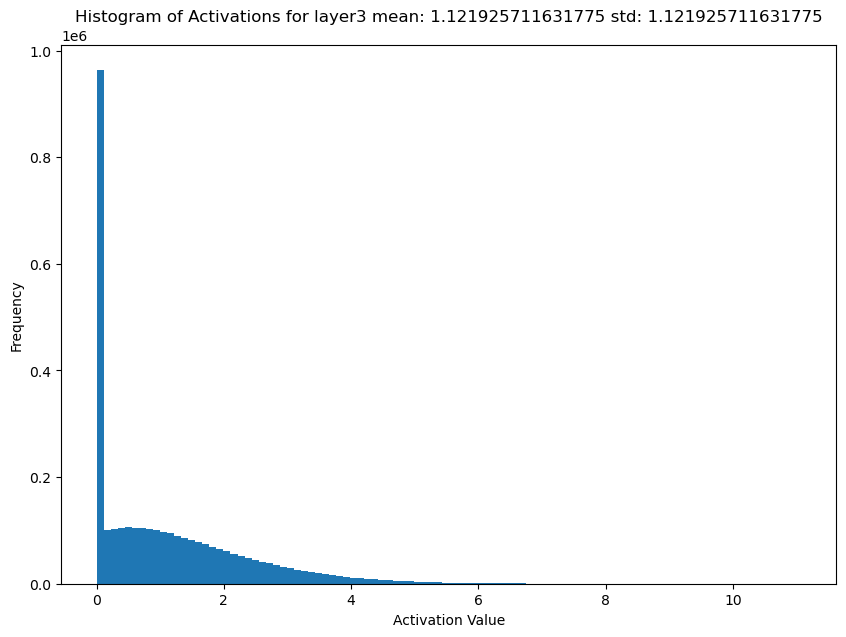

1.1807396 1.5323896


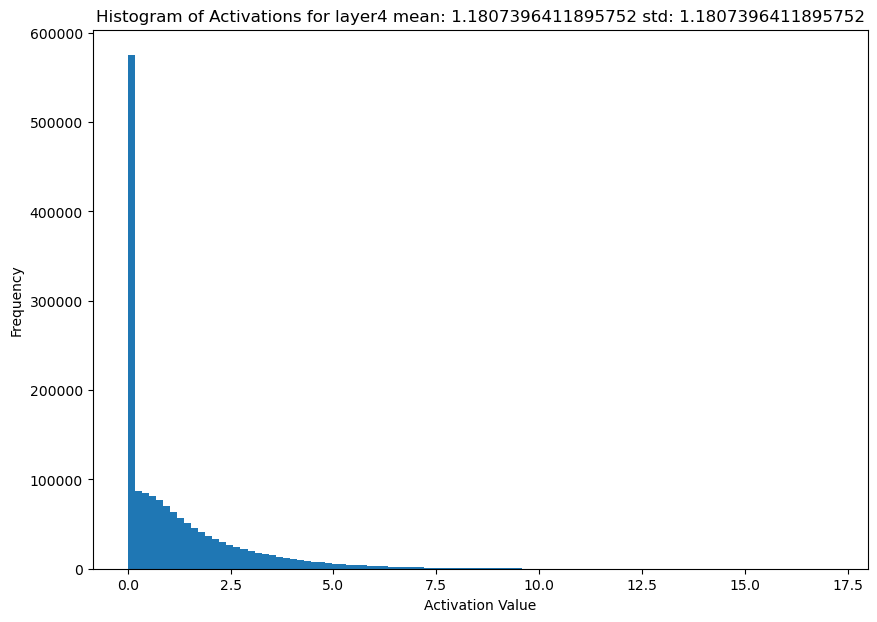

1.1807398 0.6368242


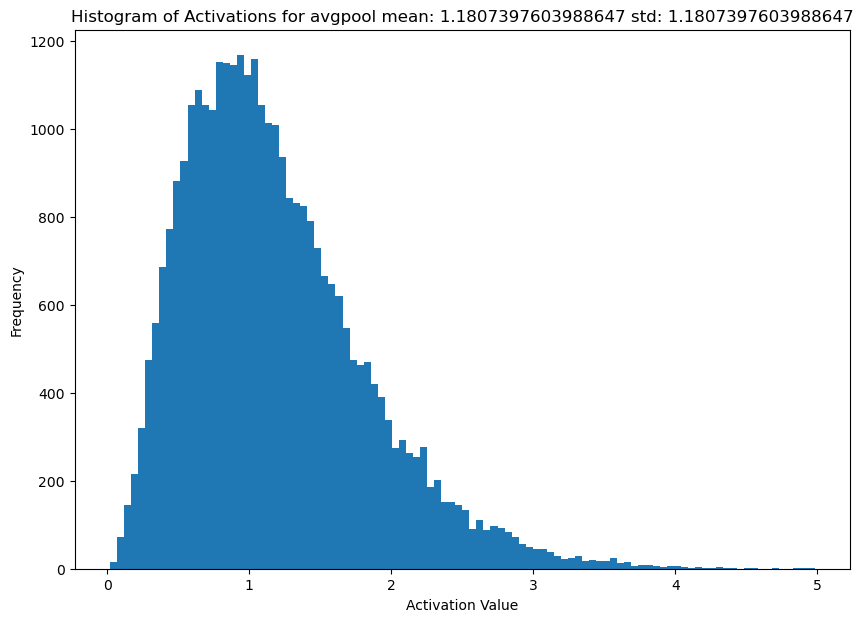

-12.042205 2.9804626


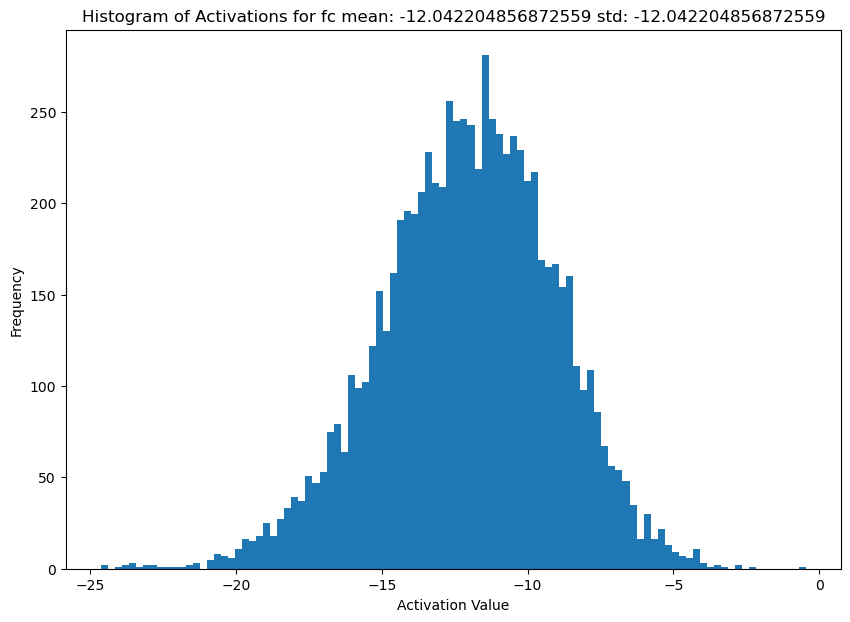

In [46]:
return_weights(resnet34, img_batch, augmentation, '../plot/pretrained')

In [25]:
arr = [5, 4, 0, 17, 19, 7, 6, 18]
def calc(x, i, n):
    cur = 1
    for k in range(i):
        cur *= x
        cur %= n
    return cur

for i in arr:
    print(f'i: {i}, val: {calc(i, 31, 161)}\n')



i: 5, val: 103

i: 4, val: 151

i: 0, val: 0

i: 17, val: 122

i: 19, val: 33

i: 7, val: 84

i: 6, val: 62

i: 18, val: 81

